<a href="https://colab.research.google.com/github/Sylar257/My-data-science-tool-kit/blob/master/Advanced_usage_for_PyTorch(torch%20hook%20included).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
1. Difference between PyTorch classes like `nn.Module`, `nn.Functional`
2. How to customize training options such as `lr` for different layers, *weight initialization*
3. **Tensorboard** with PyTorch
4. How to visualiza the computation graph and print it's intermediate values for **debugging**
5. PyTorch **Hooks** for debugging and monitoring training process

## `nn.Module` vs `nn.Functional`

PyTorch layers are normally implemented with either `torch.nn.Module` objects or `torch.nn.Functional` functions.<br>
___
With `torch.nn.Module` we define layers in `__init__` and then invoke them in `forward` method. This is a *Object Oriented* way to do things.<br>
On the other hand, `nn.functional` provides some **layers/activations** in form of *functions* that can be directly called on the input rather than defining as an object. E.g., in order to rescale an image tensor, we can call `torch.nn.functional.interpolate` on an image tensor.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# simulate an input of batch_size = 1, n_channels = 3, 64x64 image
inp = torch.randn(1,3,64,64) 


In [0]:
# torch.nn layers
avg_pool = nn.AvgPool2d(kernel_size=4)
nn_out = avg_pool(inp)

In [0]:
# torch.nn.Functional functions
f_out  = F.avg_pool2d(inp,kernel_size=4)

In [0]:
# check is the two are the same
print(torch.equal(nn_out, f_out))

True


### Stateful-ness in PyTorch
As the result of the two method are actually the same, the difference lies in their *statefulness*.<br>
In most cases, layers can be viewed as a function in PyTorch where we feed in an input and it spits out an output.In the mean time, layers holds **weights** and **biases** that need to be stored and updated while we are training. Therefore, programmatically, layers are more than just functions but hold these *states* that will be altered during our training.<br>
Hence, for layers that needs to hold certain **weights & biases** or any **states** we create a class for them with `torch.nn.Module`. **Batch Norm layers** and **dropout layers** behahves differently during training and inferernce which is also benificial to have them under `torch.nn.Module`.<br>
On the other hand, `torch.nn.functional` have the layers that bear no weights and no state.

### nn.Parameter
PyTorch has a `nn.Parameter` class, which will be automatically created with and `nn.Module`.

In [0]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5)
    
    def forward(self, x):
        return self.linear(x)

In [0]:
myNet = net()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[ 0.1716, -0.1476, -0.2967, -0.1605,  0.1744,  0.0588, -0.0607, -0.0973,
          0.0017,  0.2567],
        [-0.1697,  0.1477,  0.1557,  0.2791,  0.0775,  0.0166, -0.3029,  0.2463,
          0.0950,  0.0751],
        [ 0.1641,  0.0460, -0.1584, -0.1920,  0.1690, -0.1267, -0.2761, -0.0781,
          0.2130,  0.0741],
        [-0.1212,  0.0420, -0.1198, -0.0004, -0.2889, -0.0960, -0.0641,  0.1144,
         -0.2615,  0.0941],
        [ 0.1211,  0.1952, -0.1380, -0.2176, -0.2004, -0.0063,  0.0482,  0.1178,
         -0.2555, -0.0974]], requires_grad=True), Parameter containing:
tensor([ 0.0363, -0.1625,  0.0170, -0.2657,  0.2369], requires_grad=True)]


Every `nn.Module` has a `.parameter()` function which will return a generator that contains its **trainable parameters**. <br>
`nn.Parameter` is a subclass of the `Tensor` class. When we invoke `parameters()` function of a `nn.Module` object, it returns all it's members which are of `nn.Parameter` object.<br>


In [0]:
# if we assign a tensor to nn.Module object, it won't show up in parameter()
class net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5)
        self.tensor = torch.ones(3,4) # this won't show up in parameter list
    def forward(self, x):
        return self.linear(x)

myNet = net1()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[ 3.7555e-02, -1.4767e-01,  1.9410e-01,  1.5218e-01,  3.5893e-02,
          2.2223e-01,  6.2907e-02, -1.0649e-01, -1.6596e-01, -7.3398e-02],
        [ 2.7306e-01, -2.8168e-01,  2.5340e-01, -8.7366e-02,  7.9438e-02,
          2.8687e-01, -6.8957e-02,  1.3743e-01, -2.0911e-01,  1.1205e-01],
        [-2.5343e-01, -1.5147e-01,  1.1081e-01,  5.5938e-03, -8.1562e-02,
          1.9062e-01,  3.1233e-01, -2.4967e-01, -7.3349e-02,  2.7371e-01],
        [-1.1500e-01,  1.1376e-01,  2.0995e-01, -3.2674e-02,  1.9078e-01,
          1.5551e-04,  1.8036e-01,  1.9926e-01,  1.1221e-01,  2.6856e-01],
        [-1.1548e-01,  9.0936e-02, -2.2158e-01,  1.2729e-01,  3.0146e-01,
         -2.8080e-01, -1.4860e-01,  5.5613e-02, -5.9475e-02, -2.4967e-01]],
       requires_grad=True), Parameter containing:
tensor([-0.1166,  0.2048,  0.0324,  0.1969,  0.0412], requires_grad=True)]


In [0]:
# if we assign a parameter to nn.Module object
class net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5)
        self.tensor = nn.Parameter(torch.ones(3,4)) # this will show up in the parameter list later(first tensor)
    def forward(self, x):
        return self.linear(x)

myNet = net2()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[-0.2334,  0.1393,  0.1337,  0.2153, -0.1557,  0.0870,  0.2214, -0.1071,
         -0.2104,  0.2835],
        [ 0.2420, -0.0492, -0.0207, -0.1436, -0.1048,  0.2308, -0.2629, -0.3126,
          0.2198, -0.0791],
        [ 0.2438,  0.0797, -0.2304, -0.1093, -0.0235,  0.0010,  0.1841, -0.2489,
         -0.0359, -0.2649],
        [-0.0340, -0.2460,  0.2960,  0.1572,  0.3124,  0.2922,  0.2609,  0.0740,
         -0.1762, -0.2802],
        [ 0.1357,  0.3020, -0.2723, -0.0351, -0.2707, -0.2037, -0.2255, -0.3047,
         -0.0311,  0.2793]], requires_grad=True), Parameter containing:
tensor([-0.0610, -0.2802,  0.0327, -0.2188, -0.1466], requires_grad=True)]


### nn.ModuleList and nn.ParameterList()

In [0]:
layer_list = [nn.Conv2d(5,5,3),
              nn.BatchNorm2d(5),
              nn.Linear(5,2)]

class myNet(nn.Module):
    def __init___(self):
        super().__init__()
        self.layers = layer_list
    
    def forward(x):
        for layer in self.layers:
            x = layer(x)

In [0]:
net = myNet()
print(list(net.parameters())) # this wouldn't return of the parameters in the layers we have created

[]


We don't have any return because *Python List* does not register the parameters of Modules.<br>
For the remedy, we need to wrap the *Python List* with `nn.ModuleList` class

In [0]:
layer_list = [nn.Conv2d(5,5,3),
              nn.BatchNorm2d(5),
              nn.Linear(5,2)]

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(layer_list)
    def forward(x):
        for layer in self.layers:
            x = layer(x)

In [0]:
net = myNet()

print(list(net.parameters())) # after wrapping layer list with nn.ModuleList

[Parameter containing:
tensor([[[[ 0.0167, -0.0941, -0.0975],
          [-0.0904, -0.0776,  0.0857],
          [-0.0116, -0.1320,  0.0430]],

         [[ 0.0728, -0.0244, -0.1005],
          [ 0.0257,  0.1284,  0.1096],
          [ 0.1145, -0.0819, -0.1282]],

         [[ 0.1166, -0.0895, -0.1362],
          [-0.0459,  0.0195,  0.0245],
          [ 0.0814, -0.0519, -0.0371]],

         [[ 0.0919,  0.0754,  0.0160],
          [-0.0700,  0.0950,  0.0453],
          [-0.1389,  0.1135, -0.0531]],

         [[ 0.0958, -0.0471,  0.0050],
          [-0.1152, -0.0286,  0.0719],
          [ 0.0336, -0.0494, -0.0293]]],


        [[[ 0.1179,  0.0415, -0.1463],
          [-0.0612, -0.1056,  0.0241],
          [-0.0161, -0.0765,  0.0995]],

         [[-0.0059,  0.1078, -0.1028],
          [-0.0170, -0.0061, -0.1074],
          [-0.1286,  0.0056,  0.0240]],

         [[-0.0597, -0.0979, -0.1324],
          [-0.0622,  0.1174,  0.0270],
          [-0.0173, -0.1064, -0.0431]],

         [[ 0.0386, -0.

In [0]:
net.layers

ModuleList(
  (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=5, out_features=2, bias=True)
)

## 2. Weight Initialization
PyTorch offers different weight initialization options for us within `nn.init.`<br>
We have `constant_`&`uniform_`; `xavier_constant_`&`xavier_uniform_`; and `Kaiming_constant_`&`Kaiming_uniform`
___



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(10,10,3)
        self.bn   = nn.BatchNorm2d(10)

    def weights_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean=0.0, std = 1.0)
                nn.init.constant_(module.bias, 0)

In [0]:
Net = myNet()
Net.weights_init()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


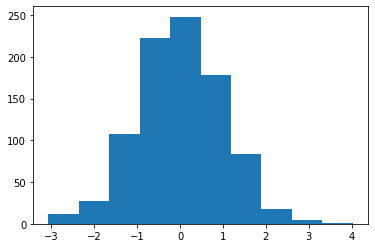

In [0]:
for module in Net.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        print(module.bias) # chech if biases are all 0
        
        plt.hist(weights)
        plt.show()


### modules() vs children()
The difference of the two is very slight but quite important. <br>
As we know, a `nn.Module` object can contain other `nn.Module` objects as it's data members. <br>
`nn.children()` will only return an *iterable* of the `nn.Module` objects which are data members. <br>
___
on the other hand, `nn.Modules` goes *recursively* inside each `nn.Module` object, printing each `nn.Module` object that comes along the way until there are no `nn.module` object left.

In [0]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convBN = nn.Sequential(nn.Conv2d(10,10,3),nn.BatchNorm2d(10))
        self.linear = nn.Linear(10,2)

    def forward(self,x):
        pass

In [0]:
Net = myNet()
print("printing children\n----------------------------------------------")
print(list(Net.children()))
print("\n\nprinting modules\n---------------------------------------------")
print(list(Net.modules()))

printing children
----------------------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


printing modules
---------------------------------------------
[myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
), Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)), BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=10, out_features=2, bias=True)]


### Summary on printing info about model
PyToch provides 4 convinient functions for printing out infomation our model:
1. `named_parameters`. Return an *iterator* which gives a tuple containing **name** of the parameters (e.g., `self.conv` would have `conv.weight` and `conv.bias`)
2. `named_modules`.  Similar to above but return `modules()` functions
3. `named_children`. Similar to above but return `children()`
4. `named_buffers`.  Return buffer tensors such as running mean average of a Batch Norm layers

In [0]:
for x in Net.named_modules():
  print(x[0], x[1], "\n-------------------------------")

 myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
) 
-------------------------------
convBN Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
convBN.0 Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)) 
-------------------------------
convBN.1 BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
-------------------------------
linear Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


In [0]:
for x in Net.named_children():
  print(x[0], x[1], "\n-------------------------------")

convBN Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
linear Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


In [0]:
for x in Net.named_children():
  print(x[0], "\n-------------------------------")

convBN 
-------------------------------
linear 
-------------------------------


In [0]:
for x in Net.named_children():
  print(x[1], "\n-------------------------------")

Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


## Different Learning Rates for Different Layers

Now we have a solid fundation to move on to learn how to apply differnt **hyper-parametes** to different layers or layer groups.<br>
With this, we will be able to apply different learning rate for each layer.

In [0]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,2)

    def forward(self, x):
        return self.fc2(self.fc1(x))

In [0]:
Net = myNet()
optimizer = torch.optim.SGD(Net.parameters(), lr=0.5)

Optionally, we can provide our optimizer with a dictionary of **learnable parameters** and their corresponding **settings**

In [0]:
optimizer = torch.optim.SGD([
                             {"params":Net.fc1.parameters(), "lr": 1e-3, "momentum":0.99},
                             {"params":Net.fc2.parameters(), "lr": 1e-2, "momentum":0.9 }
])

## Scheduling Learning Rates
PyTorch provides support for **learning rate scheduling** with it's `torch.optim.lr_scheduler` module. It has a variety of learning rate schedules.<br>
Fortunately, they are all well commented

In [0]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,max_lr=1e-3, total_steps=1000, epochs=10,steps_per_epoch=100,pct_start=0.4)

## GPU monitoring

In [0]:
!pip install gputil

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=c83c395720cc78e046592ea757d6bc3433cb3b2ffea6d614247d153bd3ddafdc
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
from GPUtil import showUtilization as gpu_usage
# gpu_usage()

# PyTorch Hooks

PyTorch hook is a tool that we can *register* to any **tensor** or **nn.Module** during our computation so that we can monitor what is going on with our `forward` and `backward` loops.<bR>
The `forward` is not refered to `nn.Module.forward` bu the `torch.Autograd.Function` object that is the `grad_fn` of a **tensor**.<br>
Notice, that a `nn.Module` like `nn.Linear` can have multiple `forward` invocations. It's output is created by two operations, $Y = W*X+B$, *addition* and *multiplication* and thus there will be two `forward` calls. 

## Hook types
1. The Forward Hook
2. The Backward Hook

A forward hook is excuted during the forward pass, while the backward hook is executed when `backward` function is called both of which are *functions* of `Autograd.Funciton` object.

A hook in PyTorch is basically a funciotn, with a very specific signature. When we say a hook is executed, in reality, we are talkingabout this function being executed.<br>
`grad` is basically the value contained in the `grad` attribute of the tensor **after** `backward` is called. The function is not supposed to modify it's argument. It must either return `None` or a Tensor which will be used in place of `grad` for further gradient computations.<br>
The below example clarifies this point:

In [0]:
a = torch.ones(10)
a.requires_grad

False

In [0]:
a.requires_grad = True
a.requires_grad

True

In [0]:
b = 2*a
b.requires_grad

True

In [0]:
print(a.is_leaf)
print(b.is_leaf)

True
False


Since `b` is not a **leaf variable**, its `grad` will by default be destroyed during computation.<br>
We can used `b.retain_grad()` to ask PyTorch to retain its `grad`

In [0]:
b.retain_grad()  

In [0]:
c = b.mean()
print(f"requires_grad: {c.requires_grad}")
print(f"is_lead: {c.is_leaf}")

requires_grad: True
is_lead: False


In [0]:
c

tensor(2., grad_fn=<MeanBackward0>)

In [0]:
c.backward()

In [0]:
print(a.grad, b.grad)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000]) tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


Now, we redo the experment but with a **hook** that multiplies `b`'s grad by 2

In [0]:
a = torch.ones(5)
a.requires_grad = True
b = 2*a
b.retain_grad()
b.register_hook(lambda x:print(x))
b.mean().backward()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


In [0]:
print(a.grad, b.grad)

tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000]) tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


In [0]:
a

tensor([1., 1., 1., 1., 1.], requires_grad=True)

In [0]:
b

tensor([2., 2., 2., 2., 2.], grad_fn=<MulBackward0>)

There are several uses of functionality as above:
1. We can print the *value* of gradient for *debugging*. We can also log them. This is especially useful with *non-lead* variables whose gradients are greed up unless we cann `retain_grad`upon them. Dping the latter can lead to increased memory retention. Hooks provide much cleaner way to aggregate these values.
2. We can modify gradient **during** the backward pass. This is very important. While we can still access the `grad` variable of a tensor in a network, we can only access it after the **entire** backward pass has been done. For example, we multiplied `b`'s gradient by 2, and now the subsequent gradient calculations, like those of `a`(or any tensor that will depend upon `b` for gradient) use `2*grad(b)` instead of `grad(b)`. In contrast, had we individually updated the parameters **after** the `backward`, we'd have to multiply `b.grad` as well as `a.grad`

In [0]:
a = torch.ones(5)
a.requires_grad = True
b = 2*a
b.retain_grad()
b.mean().backward()

print(a.grad, b.grad)

tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000]) tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


In [0]:
b.grad *= 2

print(a.grad, b.grad) # in this case, a's grad needs to be updated mannuly since we modified b's grad after backward is finished.

tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000]) tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000])


## Hooks for nn.Module objects

For **backward hook**:
`hook(module, grad_input, grad_output)`
___
For **forward hook**:
`hook(module, input, output)`
___

In [0]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,10,2, stride=2) # (8-2+0)/2+1 = 4
        self.relu = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc1  = nn.Linear(160,5)

    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.fc1(self.flatten(x))

In [0]:
Net = myNet()

In [0]:
Net.named_modules

<bound method Module.named_modules of myNet(
  (conv): Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU()
  (fc1): Linear(in_features=160, out_features=5, bias=True)
)>

In [0]:
def hook_fn(m, i, o):
    print(m)
    print("--------Input Grad--------")

    for grad in i:
        try:
            print(grad.shape)
        except AttributeError:
            print("None found for input Gradient")

    print("--------Output Grad--------")
    for grad in o:
        try:
            print(grad.shape)
        except AttributeError:
            print("None found for output Gradient")
    print("\n")


In [0]:
Net.conv.register_backward_hook(hook_fn)

In [0]:
Net.fc1.register_backward_hook(hook_fn)

In [0]:
inp = torch.rand(1,3,8,8)
out = Net(inp)

In [0]:
out

tensor([-0.1955,  0.1971, -0.0998, -0.0385, -0.0288], grad_fn=<AddBackward0>)

In [0]:
(1-out.mean()).backward()

Linear(in_features=160, out_features=5, bias=True)
--------Input Grad--------
torch.Size([5])
torch.Size([5])
--------Output Grad--------
torch.Size([5])


Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))
--------Input Grad--------
None found for input Gradient
torch.Size([10, 3, 2, 2])
torch.Size([10])
--------Output Grad--------
torch.Size([1, 10, 4, 4])




## Proper way of implementing Hooks(in **back-prop**)

We have:
1.  torch.autograd.Variable.register_hook (Python method, in Automatic differentiation package
2.  torch.nn.Module.register_backward_hook (Python method, in torch.nn)
3.  torch.nn.Module.register_forward_hook

The first `register_hook`，is for any **Variable**. It's essentially a **callback** function that is going to be executed every time when `Autograd` gradient is computed.<br>
While `Module.register_backward_hook` & `n.Module.register_forward_hook` are for `nn.Module` object and their `hook_fn` shoud take torch:
<br>`def hook_fn(m, i, o):` where `i` refers to input and `o` refers to output

#### An example
Using `named_parameters` function we can accomplish *gradient modifying/clipping*.<br>
The following example dose two things:
1. Turn gradients of linear bises into zero while back-prop (no updates for biase)
2. Make sure that for no gradient going to *conv layer* is less than 0 (all positive)

In [0]:
import torch
import torch.nn as nn

In [0]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,10,2,stride=2)
        self.relu = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc1  = nn.Linear(160,5)
    def forward(self,x):
        x = self.relu(self.conv(x))
        x.register_hook(lambda grad: torch.clamp(grad, min=0)) # minimun back-prop gradient of value 0

        # print whether there is any negative grad
        x.register_hook(lambda grad: print("Gradients less than zero:", bool((grad<0).any())))
        
        return self.fc1(self.flatten(x))

In [0]:
net = myNet()

In [0]:
for name, param in net.named_parameters():
    print(name)

conv.weight
conv.bias
fc1.weight
fc1.bias


In [0]:
for name, param in net.named_parameters():
    if 'fc' in name and 'bias' in name:
        print(name,param,sep='\n')

fc1.bias
Parameter containing:
tensor([-0.0599,  0.0697, -0.0308,  0.0265,  0.0305], requires_grad=True)


In [0]:
for name, param in net.named_parameters():
    if 'fc' in name and 'bias' in name:
        param.register_hook(lambda grad: torch.zeros_like(grad))

In [0]:
out = net(torch.randn(1,3,8,8))

In [0]:
(1-out).mean().backward()

Gradients less than zero: False


In [0]:
print(f'The biases are: {net.fc1.bias.grad}')

The biases are: tensor([0., 0., 0., 0., 0.])


## Hook implementation in **forward-prop** for Visualizating activation

The `Tensor` object doesn't have a forward hook, while `nn.Module` objects have one, which is excuted when a `forward` is called.<br>
We can use forward hooks to save intermediate feature maps by saving the feature maps to a python variable external to the hook function. See the example below:

In [0]:
visualization = {}
inp = torch.randn(1,3,8,8)

def hook_fn(m, i, o):
    visualization[m] = o
    print(f'the module is {m}')
    print(f'the input  length  is {len(i)}')
    print(f'the output length is {(len(o))}')

In [0]:
net = myNet()

In [0]:
for name, layer in net._modules.items():
    print(name,'|', layer)

conv | Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))
relu | ReLU()
fc1 | Linear(in_features=160, out_features=5, bias=True)


In [0]:
for name, layer in net._modules.items():
    layer.register_forward_hook(hook_fn)

In [0]:
out = net(inp)

the module is Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))
the input  length  is 1
the output length is 1
the module is ReLU()
the input  length  is 1
the output length is 1
the module is Linear(in_features=160, out_features=5, bias=True)
the input  length  is 1
the output length is 5


Generally, the `ouput` for a `nn.Module` is the output of the last `forward`. However, the above functionality can be safely replicated without using hooks. Just simply append the intermediate output in the forward function of `nn.Module` object to a list.<br>
However, it might be a bit problematic to print the intermediate activation of modules inside `nn.Sequential`. To get past this, we need to register a hook to **children modules** of the Sequential but not to the `Sequential` itself.

In [0]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv  = nn.Conv2d(3,10,2, stride = 2)
        self.relu  = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc1   = nn.Linear(160,5)
        self.seq   = nn.Sequential(nn.Linear(5,3), nn.Linear(3,2))

    def forward(self,x):
        x = self.relu(self.conv(x))
        x = self.fc1(self.flatten(x))
        x = self.seq(x)

In [0]:
net = myNet()
visualization={}

In [0]:
def hook_fn(m, i, o):
    visualization[m] = o

In [0]:
def get_all_layers(net):
    for name, layers in net._modules.items():
        # It one of the 'item' is a nn.Sequential, no hooks are registered
        # therefore, we can recursively register hhok on all it's module children
        if isinstance(layers, nn.Sequential):
            get_all_layers(layers)
        else:
            layers.register_forward_hook(hook_fn)

In [0]:
get_all_layers(net)

In [0]:
out = net(torch.randn(1,3,8,8))

In [0]:
visualization.keys()

dict_keys([Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2)), ReLU(), Linear(in_features=160, out_features=5, bias=True), Linear(in_features=5, out_features=3, bias=True), Linear(in_features=3, out_features=2, bias=True)])

In [0]:
x = torch.randn(1, 1)
w = torch.randn(1, 1, requires_grad=True)
w.register_hook(lambda x: print(f"w's grad is: {x}"))
y = torch.randn(1, 1)



In [0]:
out = x*w

In [0]:
loss = (out-y)**2

In [0]:
loss.register_hook(lambda x:print(f'loss is: {x}'))

In [0]:
loss.mean().backward()

loss is: tensor([[1.]])
w's grad is: tensor([[-0.3534]])


## An Toy Example to understand Pytorch Hooks

In [0]:
import numpy as np
import torch
import torch.nn as nn


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(2,2)
        self.s1  = nn.Sigmoid()
        self.fc2 = nn.Linear(2,2)
        self.s2  = nn.Sigmoid()
        self.fc1.weight = torch.nn.Parameter(torch.Tensor([[0.15,0.2],[0.250,0.30]]))
        self.fc1.bias   = torch.nn.Parameter(torch.Tensor([0.35]))
        self.fc2.weight = torch.nn.Parameter(torch.Tensor([[0.4,0.45],[0.5,0.55]]))
        self.fc2.bias   = torch.nn.Parameter(torch.Tensor([0.6]))

    def forward(self, x):
        return self.s2(self.fc2(self.s1(self.fc1(x))))

In [29]:
net = Net()
net

Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (s1): Sigmoid()
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (s2): Sigmoid()
)

In [30]:
list(net.parameters())

[Parameter containing:
 tensor([[0.1500, 0.2000],
         [0.2500, 0.3000]], requires_grad=True), Parameter containing:
 tensor([0.3500], requires_grad=True), Parameter containing:
 tensor([[0.4000, 0.4500],
         [0.5000, 0.5500]], requires_grad=True), Parameter containing:
 tensor([0.6000], requires_grad=True)]

In [31]:
weight2 = list(net.parameters())[2]
weight2

Parameter containing:
tensor([[0.4000, 0.4500],
        [0.5000, 0.5500]], requires_grad=True)

In [0]:
data = torch.Tensor([0.05, 0.1])

In [33]:
out = net(data)
target = torch.Tensor([0.01, 0.99]) # a dummy target, for example
criterion = nn.MSELoss()
loss = criterion(out, target)
loss

tensor(0.2984, grad_fn=<MseLossBackward>)

In [0]:
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [48]:
net._modules

OrderedDict([('fc1', Linear(in_features=2, out_features=2, bias=True)),
             ('s1', Sigmoid()),
             ('fc2', Linear(in_features=2, out_features=2, bias=True)),
             ('s2', Sigmoid())])

In [49]:
list(net._modules.items())

[('fc1', Linear(in_features=2, out_features=2, bias=True)),
 ('s1', Sigmoid()),
 ('fc2', Linear(in_features=2, out_features=2, bias=True)),
 ('s2', Sigmoid())]

In [50]:
# Register hooks on each layer
hookF = [Hook(layer[1]) for layer in list(net._modules.items())]
hookB = [Hook(layer[1], backward=True) for layer in list(net._modules.items())]

# run a data batch
out = net(data)

print('***'*3+'Forward Hooks Inputs & Outputs ' + '***'*3)
for hook in hookF:
    print(f'Input is: {hook.input}, and output is: {hook.output}')
    print('---'*10)
print('***'*3+'Backward Hook Inputs & Outputs ' + '***'*3)
for hook in hookB:
    print(f'Input is: {hook.input}, and output is: {hook.output}')
    print('---'*10)

*********Forward Hooks Inputs & Outputs *********
Input is: (tensor([0.0500, 0.1000]),), and output is: tensor([0.3775, 0.3925], grad_fn=<AddBackward0>)
------------------------------
Input is: (tensor([0.3775, 0.3925], grad_fn=<AddBackward0>),), and output is: tensor([0.5933, 0.5969], grad_fn=<SigmoidBackward>)
------------------------------
Input is: (tensor([0.5933, 0.5969], grad_fn=<SigmoidBackward>),), and output is: tensor([1.1059, 1.2249], grad_fn=<AddBackward0>)
------------------------------
Input is: (tensor([1.1059, 1.2249], grad_fn=<AddBackward0>),), and output is: tensor([0.7514, 0.7729], grad_fn=<SigmoidBackward>)
------------------------------
*********Backward Hook Inputs & Outputs *********


AttributeError: ignored

We have an attribute error for the above snippets because we haven't run through the backward pass. Therefore, the backward hook has register anything yet.
Below, we add in the line: `out.backward(torch.tensor([1,1]), dtyp=torch.float), retain_graph = True)`

In [54]:
# Register hooks on each layer
hookF = [Hook(layer[1]) for layer in list(net._modules.items())]
hookB = [Hook(layer[1], backward=True) for layer in list(net._modules.items())]

# run a data batch
out = net(data)
print(f'The model output is :{out} \n')

print('***'*3+'Forward Hooks Inputs & Outputs ' + '***'*3)
for hook in hookF:
    print(f'Input is: {hook.input}, and output is: {hook.output}')
    print('---'*10)

# back-prop here
out.backward(torch.tensor([2,2], dtype=torch.float), retain_graph = True)

print('***'*3+'Backward Hook Inputs & Outputs ' + '***'*3)
for hook in hookB:
    print(f'Input is: {hook.input}, and output is: {hook.output}')
    print('---'*10)

The model output is :tensor([0.7514, 0.7729], grad_fn=<SigmoidBackward>) 

*********Forward Hooks Inputs & Outputs *********
Input is: (tensor([0.0500, 0.1000]),), and output is: tensor([0.3775, 0.3925], grad_fn=<AddBackward0>)
------------------------------
Input is: (tensor([0.3775, 0.3925], grad_fn=<AddBackward0>),), and output is: tensor([0.5933, 0.5969], grad_fn=<SigmoidBackward>)
------------------------------
Input is: (tensor([0.5933, 0.5969], grad_fn=<SigmoidBackward>),), and output is: tensor([1.1059, 1.2249], grad_fn=<AddBackward0>)
------------------------------
Input is: (tensor([1.1059, 1.2249], grad_fn=<AddBackward0>),), and output is: tensor([0.7514, 0.7729], grad_fn=<SigmoidBackward>)
------------------------------
*********Backward Hook Inputs & Outputs *********
Input is: (tensor([0.0784, 0.0869]), tensor([0.1653])), and output is: (tensor([0.0784, 0.0869]),)
------------------------------
Input is: (tensor([0.0784, 0.0869]),), and output is: (tensor([0.3250, 0.3612]

In [59]:
hookB[0].input

(tensor([0.0784, 0.0869]), tensor([0.1653]))

## Interpretation of **Input** and **Output** of forward and backward passes
Things to notice:
1. Because backward pass runs from back to the start, it's **parameter order** should be reversed compared to the forward pass. Therefore, to be clearer, we will be using a different *naming convention* below.
2. For forward pass, **previous layer** of layer 2 is layer1; for backward pass, previous layer 2 is layer 3.
3. **Model output** is the output of the last layer in for ward pass.<br>
<br>

`layer.register_forward_hook(module, input, output)`:
* **Input**:  previous layer's output
* **Output**: current layer's output
    <br>

`layer.register_backward_hook(module, grad_out, grad_in)`:
* **Grad_in**: gradien of model output *w.r.t* layer output # from forward pass
    * a tensor that represent the **error of each neuron in this layer** (= gradient of modeul output *w.r.t* layer output = how much it should be improved before learning rate)
    * For the last layer: e.g. [2,2] <=> gradient of model output *w.r.t* itself, which means calculate all gradients as normal.
    * It can also be considered as a weight map: e.g. [1, 0] turn off the secon gradient; [2,1] put double weight on first gradient etc.

* **Grad_out**: Grad_in*(gradient of layer output *w.r.t* layer input)
    * =**next layer's error** (due to the chain rule)
    

In [62]:
# Comfirm the calculation with the print results above
# the 4th layer - sigmoid

forward_output = np.array([0.7514, 0.7729])
grad_in = np.array([2,2])  # Sigmoid layer

# grad of sigmoid(x) wrt x is: sigmoid(x)(1-sigmoid(x))
grad_out = grad_in*(forward_output*(1-forward_output)); grad_out

array([0.37359608, 0.35105118])

## Modify the gradients with hooks
* Hook function doesn't change gradients by default
* But if **return** is called, the returned value will be the gradient output

### Guided backpropagation with hooks - Visualize CNN(deconv)


In [0]:
class Guided_backprop():
    """
    Visualize CNN activation maps with guided backprop.
    Return: An image that represent what the network learnt for reconizing the given image.
    Methods: First layer input that minimize the error between the last layer's output, for the given class, and the true label(=1)

    ! Call visualize(image) to get the image representation
    """

    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []

        # eval mode
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        # change the modules
        modules = list(self.model.features._modules.items())

        # register hooks to relu layers
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        # register hook to the first layer
        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

        def first_layer_hook_fn(module, grad_out, grad_in):
            """
            Return reconstructed activation image
            """
            self.image_reconstruction = grad_out[0]

        def forward_hook_fn(module, input, output):
            """
            Stores the forwrad pass outputs (activation maps)
            """
            self.activation_maps.append(output)
        
        def backwrad_hook_fn(module, grad_out, grad_in):
            """
            Output the grad of model output w.r.t layer (only positive)
            """
            # Gradient of forward_output w.r.t forward_input = error of activation om map:
            # for relu layer: grad of zero = 0, grad of identity = 1
            grad = self.activation_maps[-1] # corresponding forward pass output
            grad[grad>0] = 1  # grad of reln when > 0

            # set negative output gradient to 0 #!???
            positive_grad_out = torch.clamp(input=grad_out[0], min=0.)

            # backward grad_out = grad_out*(grad of forward output w.r.t forward input)
            new_grad_out = positive_grad_out*grad

            del self.forwrad_output[-1]

            # For hook function, the returned value will be the new grad_out
            return (new_grad_out,)
    
    def visualize(self, input_image, target_class):
        # last Layer output
        model_output = self.model(input_image)
        self.model.zero_grad()

        # only calculate gradient w.r.t target class
        # set the other classes to 0:  e.g. [0,0,1]
        grad_target_map = torch.zeros(model_output.shape, dtype=torch.float)
        grad_target_map[0][target_class] = 1

        model_output.backward(grad_target_map)

        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        result = self.image_reconstruction.data.numpy()[0]
        return result


In [66]:
import torchvision
model = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:20<00:00, 27.3MB/s]


In [71]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [73]:
model.features._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

In [74]:
len(model.features._modules.items())

31

In [0]:
modules = list(model.features._modules.items())

In [78]:
modules[0][1]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))